This notebook explores a machine learning algorithm to predict the stock prices of SPY, the S&P 500 ETF, and is intended to utilize functions that can be easily translated to a python executable.

In [1]:
# installing dependencies
!pip install numpy
!pip install pandas
!pip install torch
!pip install matplotlib
!pip install alpha_vantage
!pip install scikit-learn

In [2]:
# import libararies
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from alpha_vantage.timeseries import TimeSeries 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
# config file (placing here for now, some fields will change on later impplementations)

config = {
    "alpha_vantage": {
        "key": "2JMCN347HZ3BU9RC", 
        "symbol": "SPY",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since for now we are only using close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu",
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

In [4]:
# get data from the configuration file
def get_data(config):
    ts = TimeSeries(key=config["alpha_vantage"]["key"]) 
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    date_data = [date for date in data.keys()]
    date_data.reverse()

    close_price_data = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    close_price_data.reverse()
    close_price_data = np.array(close_price_data)

    num_data_points = len(date_data)
    display_date_range = "from " + date_data[0] + " to " + date_data[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return date_data, close_price_data, num_data_points, display_date_range


date_data, close_price_data, num_data_points, display_date_range = get_data(config)

close_price_data


Number data points 5882 from 1999-11-01 to 2023-03-17


array([ 88.21718508,  87.58674188,  88.17651326, ..., 387.78232241,
       394.58604533, 389.99      ])

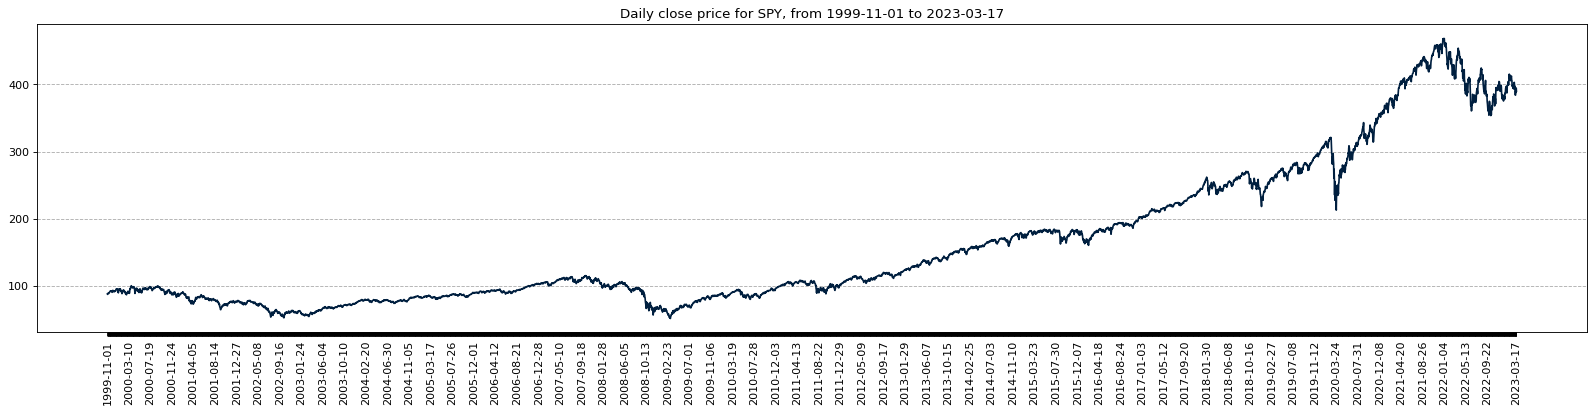

In [5]:
# plot the data (only for the demonstration here, actual graphing will occur on the front end)

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(date_data, close_price_data, color=config["plots"]["color_actual"])
xticks = [date_data[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.show()

In [6]:
# class with functions to normalize the data for more accurate predictions

class Normalization():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

    
scaler = Normalization()
normalized_close_price_data = scaler.fit_transform(close_price_data)
normalized_close_price_data

array([-0.69672838, -0.70271576, -0.69711465, ...,  2.14826834,
        2.2128839 ,  2.16923485])

In [7]:
# prep for data training

def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # use the next day as label
    output = x[window_size:]
    return output

data_x, data_x_unseen = prepare_data_x(normalized_close_price_data, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_close_price_data, window_size=config["data"]["window_size"])
data_y

array([-0.67374596, -0.66679321, -0.66157837, ...,  2.14826834,
        2.2128839 ,  2.16923485])

In [8]:
# split dataset into training and validation sets

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

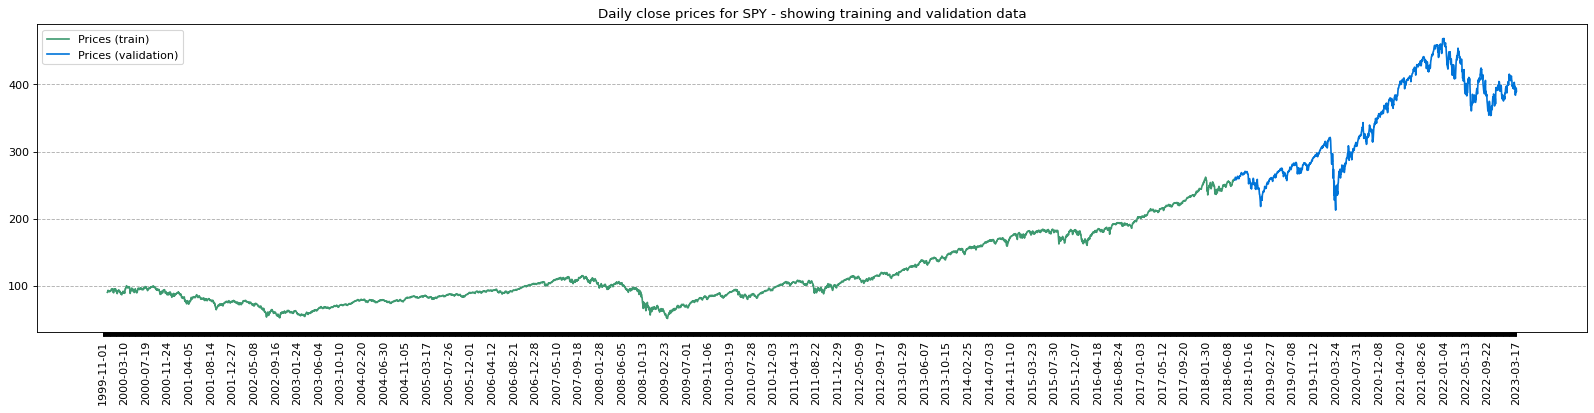

In [9]:
# prepare data for plotting

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

# plot data

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(date_data, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(date_data, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
xticks = [date_data[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] 
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

In [10]:
# Class to prepare data for training and LSTM model
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # right now we have only 1 feature, so we need to convert `x` into [batch, sequence, features]
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

# prepare and shuffle data

train_dataset = TimeSeriesDataset(data_x_train, data_y_train)
val_dataset = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", train_dataset.x.shape, train_dataset.y.shape)
print("Validation data shape", val_dataset.x.shape, val_dataset.y.shape)

train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (4689, 20, 1) (4689,)
Validation data shape (1173, 20, 1) (1173,)


In [11]:
# neural network model definition

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [12]:
# function for training LSTM model

def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr


In [13]:
# train the data

train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=True)

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/100] | loss train:0.042454, test:0.277592 | lr:0.010000
Epoch[2/100] | loss train:0.004275, test:0.227769 | lr:0.010000
Epoch[3/100] | loss train:0.003196, test:0.258616 | lr:0.010000
Epoch[4/100] | loss train:0.003573, test:0.304371 | lr:0.010000
Epoch[5/100] | loss train:0.002758, test:0.239979 | lr:0.010000
Epoch[6/100] | loss train:0.003105, test:0.182667 | lr:0.010000
Epoch[7/100] | loss train:0.002583, test:0.225696 | lr:0.010000
Epoch[8/100] | loss train:0.002507, test:0.187242 | lr:0.010000
Epoch[9/100] | loss train:0.002314, test:0.164523 | lr:0.010000
Epoch[10/100] | loss train:0.001994, test:0.170040 | lr:0.010000
Epoch[11/100] | loss train:0.002077, test:0.193066 | lr:0.010000
Epoch[12/100] | loss train:0.001839, test:0.198361 | lr:0.010000
Epoch[13/100] | loss train:0.001892, test:0.192228 | lr:0.010000
Epoch[14/100] | loss train:0.001887, test:0.142908 | lr:0.010000
Epoch[15/100] | loss train:0.002059, test:0.198726 | lr:0.010000
Epoch[16/100] | loss train:0.00189

In [14]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

    

data_y_train_pred = np.zeros(num_data_points)
data_y_val_pred = np.zeros(num_data_points)

data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

mae = mean_absolute_error(close_price_data, data_y_train_pred + data_y_val_pred)
print("Mean absolute error: ", mae)

rmse = np.sqrt(mean_squared_error(close_price_data, data_y_train_pred+data_y_val_pred))
print("Root mean squared error: ", rmse)

data_y_train_pred = np.where(data_y_train_pred == 0, None, data_y_train_pred)
data_y_val_pred = np.where(data_y_val_pred == 0, None, data_y_val_pred)


Mean absolute error:  13.063178451222932
Root mean squared error:  34.76554893755166


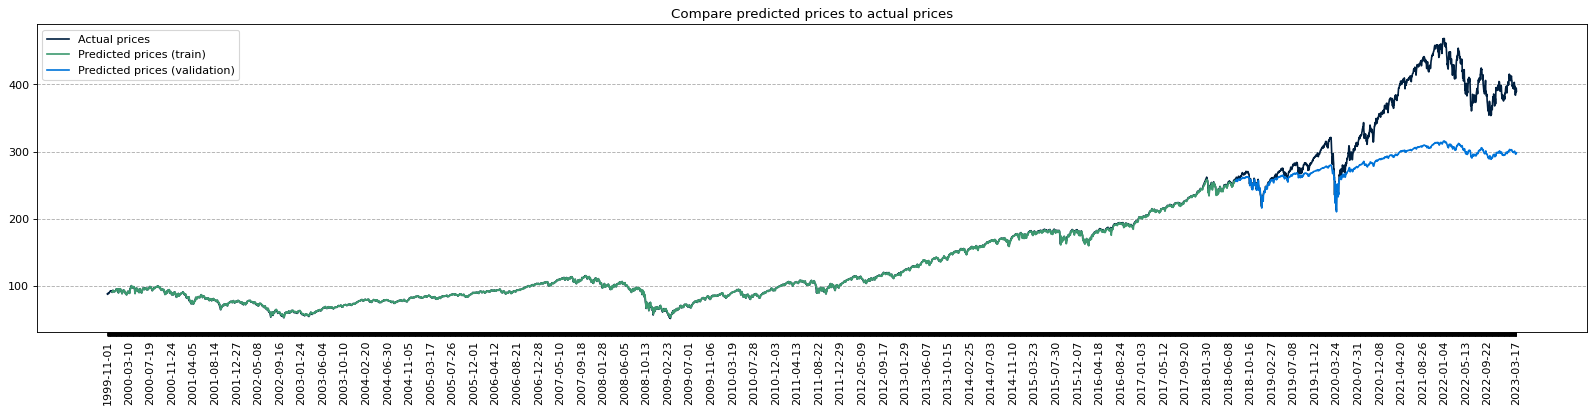

In [15]:
# plot data
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(date_data, close_price_data, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(date_data, data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(date_data, data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
xticks = [date_data[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

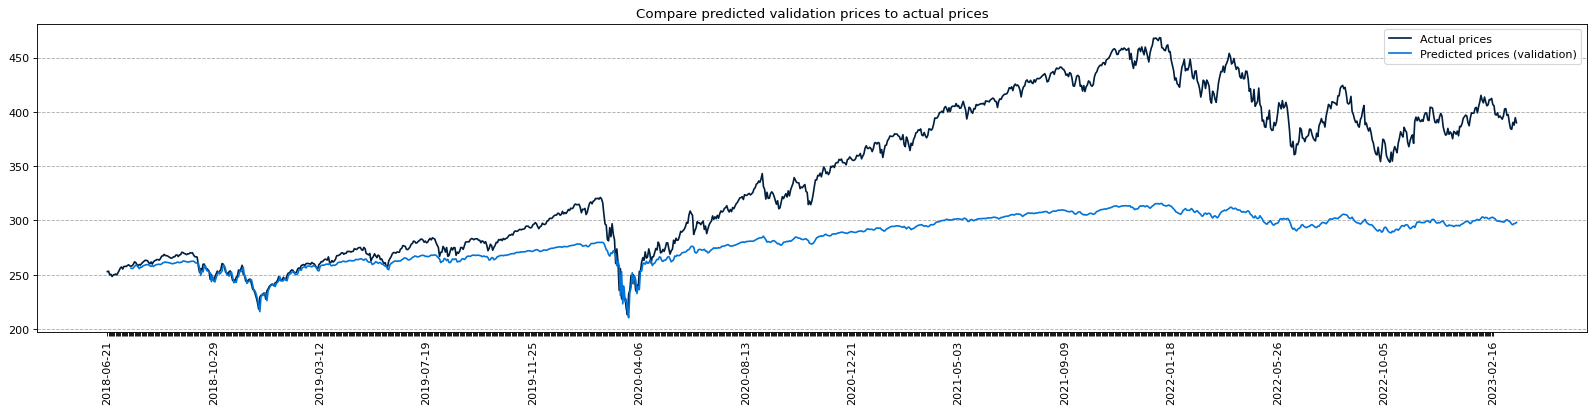

In [16]:
# plot just validation data

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(date_data[split_index:], close_price_data[split_index:], label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(date_data[split_index:], data_y_val_pred[split_index:], label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted validation prices to actual prices")
xticks = [date_data[split_index:][i] if ((i%config["plots"]["xticks_interval"]==0 and (len(val_dataset)-i) > config["plots"]["xticks_interval"]) or i==len(val_dataset)-1) else None for i in range(len(val_dataset))] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()